In [2]:
import sys
import cv2
import numpy as np
import random
from IPython.core.display import HTML

from matplotlib import pyplot as plt
%matplotlib inline

def imshow(tit, image) :
    plt.title(tit)    
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [3]:
%%writefile server.py

from flask import Flask, request

app = Flask(__name__)

@app.route('/')
def index():
    html = """
    <h1>안녕하세요<h1>
    """
    return html

datas = [45.7, 45, 10, 70.8]

@app.route('/signal')
def signal():
    global datas # global 변수인 것 명시
    datas.append( request.args.get("data") )
    return str(datas)

@app.route('/view')
def view():
    global datas # global 변수인 것 명시
    
    html = """
    """ + str(datas)
    return html


if __name__== '__main__':
    app.run(host='0.0.0.0', debug=True, port=8000)

Overwriting server.py


웹이 좋은 이유가 발달된 클라이언트 라이브러리가 많다.  

chart js를 사용하여 그래프를 그려보자  

템플릿 매칭   
얼굴검출  
보행자 검출  
QR 코드 검출

# 13장 객체 검출
---

## 템플릿 매칭  

템플릿과 가장 유사한 것이 어디에 있는지를 찾는 알고리즘  

전체 영상에서 가장 높은 값이 나오는 곳에 박스를 침.  

기본적으로 빼서 0이 나오면 정확하게 일치하는 것  

스케일이 달라지면 값이 엉뚱하게 나온다.  

- 입력 영상에서 작은 크기의 부분 영상 위치를 찾아내고 싶은 경우에 주로 템플릿 매칭 기법을 사용함.

- 템플릿 매칭은 작은 크기의 템플릿 영상을 입력 영상 천체 영역에 대해 이동하면서 가장 비슷한 위치를 수치적으로 찾아내는 방식.  


`matchTemplate(image, temp, result, method, mask)`  

result: 입력영상과 동일한 크기의 이미지에 값  


TM_SQDIFF: 제곱차 매칭 방법 (유클리안 디스턴스)  <- 빛에 매우 민감  
TMSQIDD_NORMED : 정규화된 제곱차 매칭 방법    
TM_CCORR: 상관관계 매칭 방법 (관계가 있을 때 최대값)  
TM_CCORR_NORMED: 정규화된 상관관계 매칭 방법  
__TM_CCOEFF__: 상관계수 매칭 방법 (코사인 각도를 매칭한다고 봄)  
__TM_CCOEFF_NORMED__: 정규화된 상관관계 매칭 방법  

두점이 있을 때 이루는 각도 (cos 세타) -> 크기는 보지 않고 방향선분만 보게 되어 밝기(조명)같은 것을 보지 않음  

그래서 CCOEFF를 더 많이 씀  

- 상관관계 또는 상관계수 매칭 방법을 사용할 경우에는 result 결과 행렬에서 최댓값 위치가 가장 매칭이 잘 된 위치이다.  




In [10]:
img = cv2.imread('vision/circuit.bmp', cv2.IMREAD_COLOR)
templ = cv2.imread("vision/crystal.bmp", cv2.IMREAD_COLOR)

img = img + (50, 50, 50)

noise = np.zeros(img.shape, np.int32)
cv2.randn(noise, 0, 10)
img = cv2.add(img, noise, dtype=cv2.CV_8UC3)

# res = cv2.matchTemplate(img, templ, cv2.TM_CCOEFF_NORMED)
res = cv2.matchTemplate(img, templ, cv2.TM_SQDIFF_NORMED) # 가장 성능이 떨어지는 방법

res_norm = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

minv, maxv, minloc, maxloc = cv2.minMaxLoc(res)
print('maxv:', maxv)
print('minv:', minv)

(th, tw) = templ.shape[:2]
# cv2.rectangle(img, maxloc, (maxloc[0] + tw, maxloc[1] + th), (0, 0, 255), 2)
cv2.rectangle(img, minloc, (minloc[0] + tw, minloc[1] + th), (0, 0, 255), 2) # 일단 찾긴 찾음

cv2.imshow('templ', templ)
cv2.imshow('res_norm', res_norm)
cv2.imshow('img', img)
cv2.waitKey()
cv2.destroyAllWindows()

maxv: 0.7723369598388672
minv: 0.14148284494876862


min 값이 `TM_SQDIFF_NORMED`에서는 찾은 값이다.

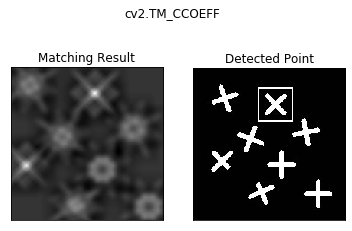

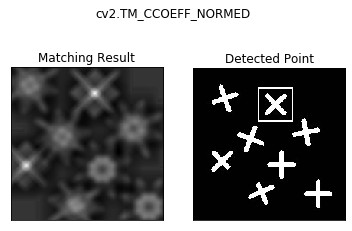

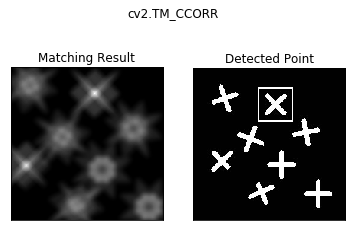

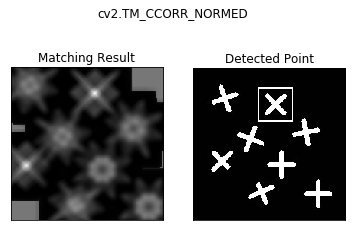

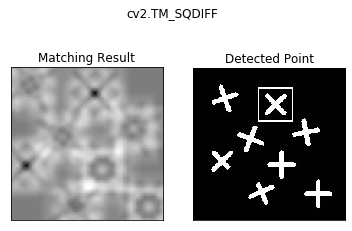

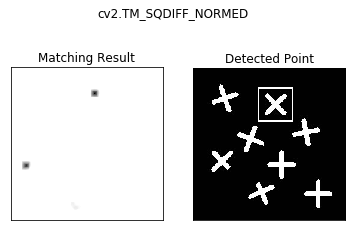

In [13]:
img = cv2.imread('vision/cross.jpg',0)
img2 = img.copy()
template = cv2.imread('vision/template.jpg',0)
w, h = template.shape[::-1]


# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)


    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc



    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(img,top_left, bottom_right, 255, 2)


    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()



In [22]:
img_bgr = cv2.imread('vision/input2.jpg')
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img2 = img.copy()
template = cv2.imread('vision/template2.jpg',0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray,template,cv2.TM_CCOEFF_NORMED)

threshold = 0.9
loc = np.where(res >= threshold)

In [23]:
loc

(array([397, 397, 397, 398, 398, 398, 398, 398, 399, 399, 399, 399, 399,
        399, 400, 400, 400, 400, 400, 400, 400, 401, 401, 401, 401, 401,
        401, 402, 402, 402, 402, 402, 403, 403, 403], dtype=int64),
 array([303, 304, 305, 302, 303, 304, 305, 306, 301, 302, 303, 304, 305,
        306, 301, 302, 303, 304, 305, 306, 307, 302, 303, 304, 305, 306,
        307, 302, 303, 304, 305, 306, 303, 304, 305], dtype=int64))

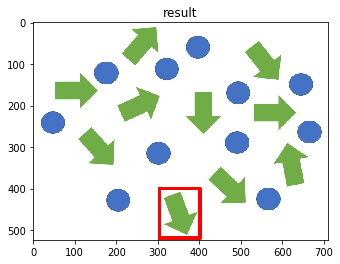

In [26]:
for pt in zip(*loc[::-1]):
    #print(pt)
    cv2.rectangle(img_bgr, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

imshow('result', img_bgr)

In [33]:
a = loc[::-1]

print(a[0])
print(a[1])

a = [1,2,3,4,5,7]
b = ['a', 'b', 'c', 'd', 'e', 'f']

for i in range(len(a)):
    print(a[i], b[i])
    
for v in zip(a,b):
    print(v)

[303 304 305 302 303 304 305 306 301 302 303 304 305 306 301 302 303 304
 305 306 307 302 303 304 305 306 307 302 303 304 305 306 303 304 305]
[397 397 397 398 398 398 398 398 399 399 399 399 399 399 400 400 400 400
 400 400 400 401 401 401 401 401 401 402 402 402 402 402 403 403 403]
1 a
2 b
3 c
4 d
5 e
7 f
(1, 'a')
(2, 'b')
(3, 'c')
(4, 'd')
(5, 'e')
(7, 'f')


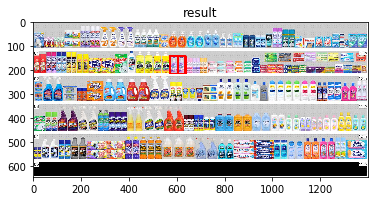

In [38]:
img_rgb = cv2.imread('vision/input4.jpg')
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('vision/template4.png', 0)
w, h = template.shape[::-1]

res = cv2.matchTemplate(img_gray, template, cv2.TM_CCOEFF_NORMED)

threshold = 0.5
loc = np.where(res >= threshold)

for pt in zip(*loc[::-1]):
    cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

imshow('result', img_rgb)

In [42]:
a = [[1,2,3],
    [4,5,6]]
for v in a:
    print(v)
    print(v[0])

[1, 2, 3]
1
[4, 5, 6]
4


In [43]:
for v in zip(a):
    print(v)
    print(v[0])

([1, 2, 3],)
[1, 2, 3]
([4, 5, 6],)
[4, 5, 6]


zip으로 묶으면 무조건 tuple로 리턴한다.  
전체원소에서 리스트가 2개이기 때문에 루프가 두번 돈다.  


In [45]:
print(a)
for v in zip(*a):
    print(v)

[[1, 2, 3], [4, 5, 6]]
(1, 4)
(2, 5)
(3, 6)


*는 언팩 하는 의미를 가진다.  


In [46]:
print(a)
for (i, v) in enumerate(a):
    print(i, v)

[[1, 2, 3], [4, 5, 6]]
0 [1, 2, 3]
1 [4, 5, 6]


In [47]:
print(a)
for k in enumerate(a):
    print(k[0], k[1])

[[1, 2, 3], [4, 5, 6]]
0 [1, 2, 3]
1 [4, 5, 6]


In [51]:
def fun(a, b, c):
    print(a, b, c)
    
fun(1,4,5)

fun(*[1,4,5])

1 4 5
1 4 5


# 얼굴 검출
---


## 캐스케이드 분류기와 얼굴 검출  

검출이 어려운 이유는 모든 위치(픽셀)에서 찾아야하기 때문이다.  

2001년에 나왔는데 거의 10년간은 이 알고리즘을 사용했다.  

기본적인 방식은 템플릿의 크기는 24x24이다. 이것을 영상에 가져다가 대보는 것이다.  

- 비올라와 존스가 개발한 객체 검출 알고리즘은 기본적으로 다양한 객체를 검출할 수 있지만, 특히  

유사-하르 필터란 특정한 값들로 이루어진 매트릭스를 말하는데 양수인 부분과 음수인 부분으로 나누어진 필터이다.  

다양한 형태의 필터가 존재한다.  

이런 간단한 필터를 수만개 사용하여 얼굴을 검출한다.  

- 유사-하르 필터 형태에서 흰색 영역 픽셀 값은 모두 더하고 검은색은 뺀다.  



1단계에서는 하나의 특징만 사용하고  

2단계에서는 다섯개를 사용한다.  

3단계에서는 특징 20개를 사용한다.  

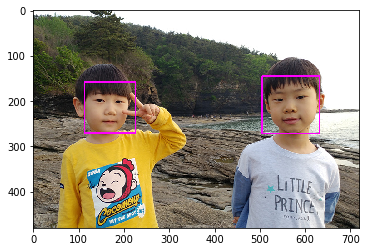

In [53]:
src = cv2.imread('vision/kids.png')
classifier = cv2.CascadeClassifier('vision/haarcascade_frontalface_default.xml')

faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
        cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)

imshow("", src)

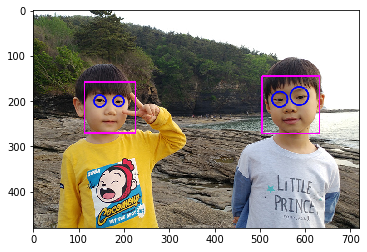

In [58]:
src = cv2.imread('vision/kids.png')
face_classifier = cv2.CascadeClassifier('vision/haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('vision/haarcascade_eye.xml')


faces = face_classifier.detectMultiScale(src)

for (x1, y1, w1, h1) in faces:
    cv2.rectangle(src, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)
    faceROI = src[y1:y1 + h1, x1:x1 + w1]
    eyes = eye_classifier.detectMultiScale(faceROI)
    for (x2, y2, w2, h2) in eyes:
            center = (int(x2 + w2 / 2), int(y2 + h2 / 2))
            cv2.circle(faceROI, center, int(w2 / 2), (255, 0, 0), 2, cv2.LINE_AA)
imshow("", src)

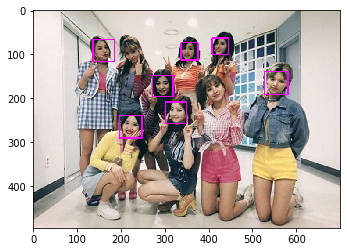

In [57]:
src = cv2.imread('vision/face.jpg')
classifier = cv2.CascadeClassifier('vision/haarcascade_frontalface_default.xml')

faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
        cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 255), 2)

imshow("", src)

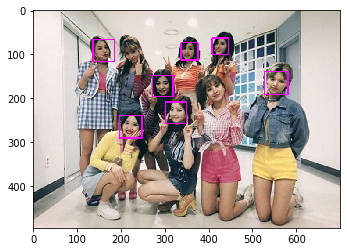

In [61]:
src = cv2.imread('vision/face.jpg')
face_classifier = cv2.CascadeClassifier('vision/haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('vision/haarcascade_eye.xml')


faces = face_classifier.detectMultiScale(src)

for (x1, y1, w1, h1) in faces:
    cv2.rectangle(src, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)
    faceROI = src[y1:y1 + h1, x1:x1 + w1]
    eyes = eye_classifier.detectMultiScale(faceROI)
    for (x2, y2, w2, h2) in eyes:
            center = (int(x2 + w2 / 2), int(y2 + h2 / 2))
            cv2.circle(faceROI, center, int(w2 / 2), (255, 0, 0), 2, cv2.LINE_AA)
imshow("", src)

# adaBoost

weak classifier를 가지고 strong classifier를 만드는 것  

직선을 가지고 만들면 오류가 무조건 나울 수 밖에 없다.  

dicision tree는 동일한 웨이트를 가졌는데  

분류하기 어려운 애들만 웨이트 값을 높혀 학습시키는 알고리즘이다. 



In [66]:
cap = cv2.VideoCapture(0)

while(1):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    face_classifier = cv2.CascadeClassifier('vision/haarcascade_frontalface_default.xml')
    eye_classifier = cv2.CascadeClassifier('vision/haarcascade_eye.xml')


    faces = face_classifier.detectMultiScale(gray)

    for (x1, y1, w1, h1) in faces:
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)
        faceROI = frame[y1:y1 + h1, x1:x1 + w1]
        eyes = eye_classifier.detectMultiScale(faceROI)
        for (x2, y2, w2, h2) in eyes:
                center = (int(x2 + w2 / 2), int(y2 + h2 / 2))
                cv2.circle(frame, center, int(w2 / 2), (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow('frame', frame)
    cv2.imshow("ROI", faceROI)
    # 30정도면 시스템에 큰 문제가 없다.
    if cv2.waitKey(10) == 27:
        break
        
cv2.destroyAllWindows()

# QR 코드 검출

In [7]:
detector = cv2.QRCodeDetector()

frame = cv2.imread("vision/acronet.png") 
# frame = cv2.imread("vision/3.png") # 여러개 붙어있으면 인식못함
info, points, _ = detector.detectAndDecode(frame)

In [8]:
print(info)
print(points.shape)
print(points)

AttributeError: 'NoneType' object has no attribute 'shape'

In [6]:
points = np.array(points, dtype=np.int32).reshape(4,2)
cv2.polylines(frame, [points], True, (0, 0, 255), 2)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

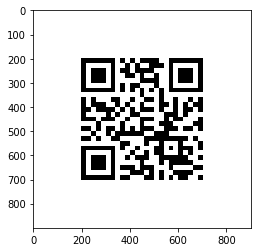

In [9]:
import qrcode
qr = qrcode.QRCode(version = 2, box_size=20, border =10)



url = 'http://192.168.1.194:8000'
qr.add_data(url)

qr.make()

img = qr.make_image(fill_color="black", back_color="white")

plt.imshow(img, cmap="gray")

img.save("acronet.png")

In [10]:
from pyzbar.pyzbar import decode
from PIL import Image

image = cv2.imread("acronet.png")
code = decode(image)
print(code)

[Decoded(data=b'http://192.168.1.194:8000', type='QRCODE', rect=Rect(left=204, top=204, width=494, height=494), polygon=[Point(x=204, y=204), Point(x=204, y=695), Point(x=698, y=698), Point(x=695, y=204)])]


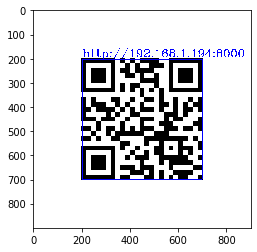

In [11]:
for barcode in code:
    (x, y, w, h) = barcode.rect
    cv2.rectangle(image, (x,y), (x+w, y+h), (0, 0, 255), 2)
    
    barcodeData = barcode.data.decode("utf-8")
    barcodeType = barcode.type
    
    text = "{} ({})".format(barcodeData, barcodeType)
    cv2.putText(image, text, (x, y -10), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 2)
    
plt.imshow(image)
    

<class 'qrcode.image.pil.PilImage'>


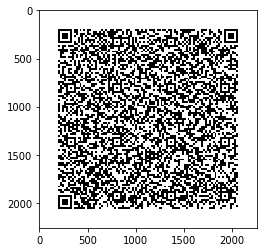

In [12]:
import qrcode

qr = qrcode.QRCode(version = 2,  box_size = 20,  border = 10)
url = 'https://www.google.com/search?hl=en&sxsrf=ALeKk02Bahr9TRRCUActvMj6uwIUanqgLw%3A1597307787651&source=hp&ei=i_s0X6XiJdb7wAPez7k4&q=%EC%84%9C%EC%9A%B8+%EB%82%A0%EC%94%A8&oq=%EC%84%9C%EC%9A%B8+%EB%82%A0%EC%94%A8&gs_lcp=CgZwc3ktYWIQAzIHCAAQRhCAAjICCAAyAggAMgIIADICCAAyAggAMgIIADICCAAyAggAMgIIADoHCCMQ6gIQJzoECCMQJzoFCAAQkQI6CwguEMcBEKMCEJMCOggILhDHARCvAToCCC46BggAEAoQKjoECC4QCjoECAAQCjoKCC4QxwEQowIQCjoECAAQHjoGCAAQChAeOggIABCxAxCDAToFCAAQsQM6BAgAEANQuxJYtiZgzShoBnAAeAGAAZsBiAHqDZIBBDAuMTWYAQCgAQGqAQdnd3Mtd2l6sAEK&sclient=psy-ab&ved=0ahUKEwjl05ya45frAhXWPXAKHd5nDgcQ4dUDCAc&uact=5'
qr.add_data(url)
qr.make()

img = qr.make_image(fill_color="black", back_color="white")
print(type(img))

plt.imshow(img, cmap="gray")

img.save("myurl.png")
